In [3]:
# Imports for EDA and beyond
import pandas as pd
import numpy as np
import re

import time

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer

In [4]:
# Imports: NOT USED
from geopy.distance import vincenty
from geopy.geocoders import Nominatim

In [5]:
# Testing some Geopy stuff
# newport_ri = (41.49008, -71.312796)
# cleveland_oh = (41.499498, -81.695391)
# print(vincenty(newport_ri, cleveland_oh).miles)

---

# EDA and Organization

In [6]:
# Read in dataset and holdout dataset
df = pd.read_csv('./Original_Data/train.csv')
df_holdout = pd.read_csv('./Original_Data/test.csv')

In [7]:
# Separate our X and y from dataset, and set our X from holdout dataset
X = df.drop('WnvPresent', axis=1)
X_holdout = df_holdout
y = df['WnvPresent']

In [8]:
# Looks like our target is included in the Train set
print(X.shape)
print(X_holdout.shape)
print(y.shape)

(10506, 11)
(116293, 11)
(10506,)


In [9]:
# Going to have VERY unbalanced classes
Counter(y)

Counter({0: 9955, 1: 551})

In [10]:
X.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos'],
      dtype='object')

In [11]:
X_holdout.columns

Index(['Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy'],
      dtype='object')

In [12]:
# Looks like our dataset has a column our houldout dataset does not ('NumMosquitos'), and our holdout dataset has a column our
# dataset does not ('Id'). We'll drop 'NumMosquitos' from dataset, since we won't have that information to work
# from in our holdout dataset, and add a sequential Id

X['Id'] = range(1,len(X)+1)
X.drop('NumMosquitos', axis=1, inplace=True)

In [13]:
# Shapes/Columns look good now
print(X.shape)
print(X_holdout.shape)
print(y.shape)

(10506, 11)
(116293, 11)
(10506,)


In [14]:
# Convert Date columns to datetime type
X['Date'] = pd.to_datetime(X['Date'])
X_holdout['Date'] = pd.to_datetime(X_holdout['Date'])

---

# New Feature Generation

In [15]:
# Create new features out of Date
X['Year'] = X['Date'].map(lambda x: x.year)
X['Month'] = X['Date'].map(lambda x: x.month)
X['Day'] = X['Date'].map(lambda x: x.day)
X['DayofYear'] = X['Date'].map(lambda x: x.dayofyear)

X_holdout['Year'] = X_holdout['Date'].map(lambda x: x.year)
X_holdout['Month'] = X_holdout['Date'].map(lambda x: x.month)
X_holdout['Day'] = X_holdout['Date'].map(lambda x: x.day)
X_holdout['DayofYear'] = X_holdout['Date'].map(lambda x: x.dayofyear)

In [16]:
# Create new feature of Zip Code

zipcodes = []
for i in X['Address']:
    try:
        zipcode = re.findall('[\d][\d][\d][\d][\d]', i)[0]
    except:
        zipcode = ''
    zipcodes.append(zipcode)
    
zipcodes_holdout = []
for i in X_holdout['Address']:
    try:
        zipcode = re.findall('[\d][\d][\d][\d][\d]', i)[0]
    except:
        zipcode = ''
    zipcodes_holdout.append(zipcode)
    
X['Zipcode'] = zipcodes
X_holdout['Zipcode'] = zipcodes_holdout

In [17]:
# Convert Block to string type
X['Block'] = X['Block'].map(lambda x: str(x))
X_holdout['Block'] = X_holdout['Block'].map(lambda x: str(x))

X['Year'] = X['Year'].map(lambda x: str(x))
X_holdout['Year'] = X_holdout['Year'].map(lambda x: str(x))

X['Month'] = X['Month'].map(lambda x: str(x))
X_holdout['Month'] = X_holdout['Month'].map(lambda x: str(x))

In [18]:
# Count Vectorize some features for X_train

cvec_spec = CountVectorizer()
X_spec = cvec_spec.fit_transform(X['Species'])
X_spec = pd.DataFrame(X_spec.todense(), columns=cvec_spec.get_feature_names())

cvec_zip = CountVectorizer()
X_zip = cvec_zip.fit_transform(X['Zipcode'])
X_zip = pd.DataFrame(X_zip.todense(), columns=cvec_zip.get_feature_names())

#cvec_block = CountVectorizer()
#X_block = cvec_block.fit_transform(X['Block'])
#X_block = pd.DataFrame(X_block.todense(), columns=cvec_block.get_feature_names())

cvec_trap = CountVectorizer()
X_trap = cvec_trap.fit_transform(X['Trap'])
X_trap = pd.DataFrame(X_trap.todense(), columns=cvec_trap.get_feature_names())

#cvec_year = CountVectorizer()
#X_year = cvec_year.fit_transform(X['Year'])
#X_year = pd.DataFrame(X_year.todense(), columns=cvec_year.get_feature_names())

cvec_month = CountVectorizer()
X_month = cvec_month.fit_transform(X['Month'])
X_month = pd.DataFrame(X_month.todense(), columns=cvec_month.get_feature_names())

#X = pd.concat([X, X_spec, X_zip, X_block, X_trap, X_year, X_month], axis=1)
X = pd.concat([X, X_spec, X_zip, X_trap, X_month], axis=1)

In [19]:
# Count Vectorize some features for X_test

X_holdout_spec = cvec_spec.transform(X_holdout['Species'])
X_holdout_spec = pd.DataFrame(X_holdout_spec.todense(), columns=cvec_spec.get_feature_names())

X_holdout_zip = cvec_zip.transform(X_holdout['Zipcode'])
X_holdout_zip = pd.DataFrame(X_holdout_zip.todense(), columns=cvec_zip.get_feature_names())

#X_holdout_block = cvec_block.transform(X_holdout['Block'])
#X_holdout_block = pd.DataFrame(X_holdout_block.todense(), columns=cvec_block.get_feature_names())

X_holdout_trap = cvec_trap.transform(X_holdout['Trap'])
X_holdout_trap = pd.DataFrame(X_holdout_trap.todense(), columns=cvec_trap.get_feature_names())

#X_holdout_year = cvec_year.transform(X_holdout['Year'])
#X_holdout_year = pd.DataFrame(X_holdout_year.todense(), columns=cvec_year.get_feature_names())

X_holdout_month = cvec_month.transform(X_holdout['Trap'])
X_holdout_month = pd.DataFrame(X_holdout_month.todense(), columns=cvec_month.get_feature_names())

#X_holdout = pd.concat([X_holdout, X_holdout_spec, X_holdout_zip, X_holdout_block, X_holdout_trap,
#                      X_holdout_year, X_holdout_month], axis=1)
X_holdout = pd.concat([X_holdout, X_holdout_spec, X_holdout_zip, X_holdout_trap, X_holdout_month], axis=1)

## Incorporate Weather Data

In [20]:
weather = pd.read_csv('./weather_odd.csv')
weather.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

weather_holdout = pd.read_csv('./weather_even.csv')
weather_holdout.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

In [21]:
weather['Date'] = pd.to_datetime(weather['Date'])
weather_holdout['Date'] = pd.to_datetime(weather_holdout['Date'])

In [22]:
print(weather.shape)
print(weather_holdout.shape)

(729, 40)
(735, 40)


In [23]:
print(X.shape)
print(X_holdout.shape)

(10506, 210)
(116293, 210)


In [24]:
# Engineer an 'Hours_in_Day' feature

sunrise_hrs = []
sunrise_mins = []

for i in range(len(weather)):
    time_tokens = list(str(weather['Sunrise'][i]))
    minute = int(time_tokens[-2] + time_tokens[-1])
    sunrise_mins.append( minute )
    try:
        hour = int(time_tokens[-4] + time_tokens[-3])
        sunrise_hrs.append( hour )
    except:
        hour = int(time_tokens[0])
        sunrise_hrs.append( hour )
        
sunset_hrs = []
sunset_mins = []

for i in range(len(weather)):
    time_tokens = list(str(weather['Sunset'][i]))
    minute = int(time_tokens[-2] + time_tokens[-1])
    sunset_mins.append( minute )
    try:
        hour = int(time_tokens[-4] + time_tokens[-3])
        sunset_hrs.append( hour )
    except:
        hour = int(time_tokens[0])
        sunset_hrs.append( hour )

In [25]:
weather['Hours_in_Day'] = (sunset_hrs + (np.array(sunset_mins) / 60) - sunrise_hrs + (np.array(sunrise_mins) / 60))

In [26]:
# Engineer an 'Hours_in_Day' feature in Holdout

sunrise_hrs = []
sunrise_mins = []

for i in range(len(weather_holdout)):
    time_tokens = list(str(weather_holdout['Sunrise'][i]))
    minute = int(time_tokens[-2] + time_tokens[-1])
    sunrise_mins.append( minute )
    try:
        hour = int(time_tokens[-4] + time_tokens[-3])
        sunrise_hrs.append( hour )
    except:
        hour = int(time_tokens[0])
        sunrise_hrs.append( hour )
        
sunset_hrs = []
sunset_mins = []

for i in range(len(weather_holdout)):
    time_tokens = list(str(weather_holdout['Sunset'][i]))
    minute = int(time_tokens[-2] + time_tokens[-1])
    sunset_mins.append( minute )
    try:
        hour = int(time_tokens[-4] + time_tokens[-3])
        sunset_hrs.append( hour )
    except:
        hour = int(time_tokens[0])
        sunset_hrs.append( hour )

In [27]:
weather_holdout['Hours_in_Day'] = (sunset_hrs + (np.array(sunset_mins) / 60) - sunrise_hrs + (np.array(sunrise_mins) / 60))

In [28]:
# Merge our X's with the weather data
X = X.merge(weather, how='left', on='Date')
X_holdout = X_holdout.merge(weather_holdout, how='left', on='Date')

In [29]:
print(X.shape)
print(X_holdout.shape)

(10506, 250)
(116293, 250)


In [30]:
# Let's drop some X (See README for explanations)
drop_cols = ['Date', 'Address', 'Species', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy', 'CodeSum', 'Year_y', 
             'Month_y', 'Day_y', 'Unnamed: 24', 'Zipcode', 'Block', 'Trap']
X.drop(drop_cols, axis=1, inplace=True)
X_holdout.drop(drop_cols, axis=1, inplace=True)

In [31]:
print(X.shape)
print(X_holdout.shape)
print(y.shape)

(10506, 236)
(116293, 236)
(10506,)


In [32]:
# Will have to balance our classes!!

In [33]:
X.to_csv('./X_train_clean_v2.csv')
X_holdout.to_csv('./X_test_clean_v2.csv')

---

# Modeling

In [35]:
# Imports for Modeling
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler

from operator import itemgetter

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

%matplotlib inline

### Baseline Accuracy (Although, we're optimizing for Recall, so this isn't really useful)

In [36]:
Counter(y)

Counter({0: 9955, 1: 551})

In [37]:
baseline = 9955/(551+9955)
baseline

0.9475537787930707

### Final EDA

In [38]:
# ID and Day_x is erroneous, Year_x is useless since there's no overlap between train and test set, Month_X will have
# strong collinearity with Day_of_Year
drop_cols = ['Id', 'Year_x', 'Month_x', 'Day_x']

In [39]:
X.drop(drop_cols, axis=1, inplace=True)
X_holdout.drop(drop_cols, axis=1, inplace=True)

In [40]:
print(X.shape)
print(X_holdout.shape)
print(y.shape)

(10506, 232)
(116293, 232)
(10506,)


In [41]:
# Join X and y momentarily so we can drop some null observations
df = X.join(pd.DataFrame(y))
print(df.shape)
df.head()

(10506, 233)


,Latitude,Longitude,DayofYear,culex,erraticus,pipiens,restuans,salinarius,tarsalis,territans,...,MIFG,RA,SN,SQ,TS,TSRA,VCFG,VCTS,Hours_in_Day,WnvPresent
0,41.954690,-87.800991,149,1,0,1,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.633333,0
1,41.954690,-87.800991,149,1,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.633333,0
2,41.994991,-87.769279,149,1,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.633333,0
3,41.974089,-87.824812,149,1,0,1,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.633333,0
4,41.974089,-87.824812,149,1,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.633333,0


In [42]:
# Split X and y back out after dropping null observations
df.dropna(inplace=True)
X = df.drop('WnvPresent', axis=1)
y = df['WnvPresent']

In [43]:
print(X.shape)
print(y.shape)
print(X_holdout.shape)

(10413, 232)
(10413,)
(116293, 232)


## Play with Subsetting Features

In [44]:
#features = ['Latitude', 'Longitude','pipiens', 'restuans', 'salinarius',
#            'territans', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool',
#            'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed', 'BR', 'DZ',
#            'FG', 'HZ', 'RA', 'TS', 'TSRA']

#features = [item[0] for item in sorted_importance][0:20]
#X = X[features]
#X_holdout = X_holdout[features]

## Test/Train Split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [46]:
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

### Balance Classes by: Oversampling (SMOTE)

In [47]:
# Oversampling on training data only
sm = SMOTE(random_state=42, ratio = 'minority')
X_res, y_res = sm.fit_sample(Xs_train, y_train)

In [48]:
print(X_res.shape)
print(y_res.shape)

(13806, 232)
(13806,)


### Test/Train Split again on Training Data, and Oversample on Training_2

In [49]:
# An additional test/train split, since we can't evaluate cross-val on original X_test if modeling was trained on
# a corresponing X_train of artificially inflated data
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_res, y_res, test_size=0.3, random_state=42, stratify=y_res)

In [50]:
print(X_train_2.shape)
print(y_train_2.shape)
print(X_test_2.shape)
print(y_test_2.shape)

(9664, 232)
(9664,)
(4142, 232)
(4142,)


### Random Forest

In [51]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_2, y_train_2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [52]:
y_preds = rf.predict(Xs_test)
print(classification_report(y_test, y_preds))
pd.DataFrame(confusion_matrix(y_test, y_preds), columns=['Pred -', 'Pred +'], index=['Act -', 'Act +'])

             precision    recall  f1-score   support

          0       0.96      0.97      0.96      2959
          1       0.25      0.19      0.22       165

avg / total       0.92      0.93      0.92      3124



,Pred -,Pred +
Act -,2862,97
Act +,133,32


In [53]:
zipped = list(zip(X_train.columns, rf.feature_importances_))
sorted_importance = sorted(zipped, key=itemgetter(1), reverse=True)
sorted_importance

[('Sunset', 0.08381325068431573),
 ('DayofYear', 0.08155804816546172),
 ('pipiens', 0.07532999447955298),
 ('Hours_in_Day', 0.05566806830980986),
 ('restuans', 0.0471256988115619),
 ('Sunrise', 0.04055205919003505),
 ('Depart', 0.03702912600022774),
 ('Longitude', 0.03547963500910475),
 ('WetBulb', 0.035472487335804215),
 ('Latitude', 0.03422500463165259),
 ('Tmin', 0.03415991181837901),
 ('ResultSpeed', 0.03004490807520786),
 ('Cool', 0.02904194702257588),
 ('StnPressure', 0.02608463253769263),
 ('Tavg', 0.02403075502059367),
 ('SeaLevel', 0.021692164576107297),
 ('ResultDir', 0.02165632691282622),
 ('t900', 0.020509022716558703),
 ('Tmax', 0.02015355939148219),
 ('DewPoint', 0.019808134126902),
 ('AvgSpeed', 0.019739932115690948),
 ('PrecipTotal', 0.0154439931964862),
 ('t115', 0.01444888235484674),
 ('BR', 0.01406683974629368),
 ('RA', 0.013972531937608163),
 ('60666', 0.011079090555423252),
 ('TSRA', 0.009980876543461564),
 ('HZ', 0.0060296807750488575),
 ('TS', 0.00450652363474164

In [56]:
pd.DataFrame(sorted_importance[0:5], columns=['Feature', 'Importance'])

,Feature,Importance
0,Sunset,0.083813
1,DayofYear,0.081558
2,pipiens,0.075330
3,Hours_in_Day,0.055668
4,restuans,0.047126


In [57]:
proba_pairs = rf.predict_proba(Xs_test)
probas = [item[1] for item in proba_pairs]
roc_auc_score(y_test, probas)

0.730761825760136

### Random Forest with Gridsearch

In [58]:
from sklearn.metrics import make_scorer

In [59]:
def custom_recall(y_true, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None):
    TP = 0
    FN = 0
    FP = 0
    TN = 0
    y_pred = list(y_pred)
    y_true = list(y_true)
    
    for i in range(len(y_true)):
        if y_true[i] == 1 and y_pred[i] == 1:
            TP += 1
        if y_true[i] == 1 and y_pred[i] == 0:
            FN += 1
        if y_true[i] == 0 and y_pred[i] == 1:
            FP += 1
        if y_pred[i] == 0 and y_pred[i] == 0:
            TN += 1
    return(TP / (TP + FN))

In [60]:
my_scorer = make_scorer(custom_recall)

In [61]:
rt_params = {'n_estimators':[2,5,10,15,25],
            'criterion':['gini','entropy'],
            'max_depth':[2,5,10,20,None],
            'min_samples_split':[2,5,10],
            'random_state':[42]}

rt_grid = GridSearchCV(RandomForestClassifier(), rt_params, scoring=my_scorer, cv=5)
rt_grid.fit(X_train_2, y_train_2)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [2, 5, 10, 15, 25], 'criterion': ['gini', 'entropy'], 'max_depth': [2, 5, 10, 20, None], 'min_samples_split': [2, 5, 10], 'random_state': [42]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(custom_recall), verbose=0)

In [62]:
y_preds = rt_grid.predict(Xs_test)
print(classification_report(y_test, y_preds))
pd.DataFrame(confusion_matrix(y_test, y_preds), columns=['Pred -', 'Pred +'], index=['Act -', 'Act +'])

             precision    recall  f1-score   support

          0       0.97      0.84      0.90      2959
          1       0.17      0.59      0.27       165

avg / total       0.93      0.83      0.87      3124



,Pred -,Pred +
Act -,2498,461
Act +,68,97


In [63]:
rt_grid.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_split': 5,
 'n_estimators': 15,
 'random_state': 42}

In [64]:
proba_pairs = rt_grid.predict_proba(Xs_test)
probas = [item[1] for item in proba_pairs]
roc_auc_score(y_test, probas)

0.8077483179206735

### Random Trees with Random Search

In [65]:
rt_rand = RandomizedSearchCV(RandomForestClassifier(), rt_params, scoring=my_scorer, cv=5, n_iter=50, random_state=42)
rt_rand.fit(X_train_2, y_train_2)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'n_estimators': [2, 5, 10, 15, 25], 'criterion': ['gini', 'entropy'], 'max_depth': [2, 5, 10, 20, None], 'min_samples_split': [2, 5, 10], 'random_state': [42]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=make_scorer(custom_recall),
          verbose=0)

In [66]:
y_preds = rt_rand.predict(Xs_test)
print(classification_report(y_test, y_preds))
pd.DataFrame(confusion_matrix(y_test, y_preds), columns=['Pred -', 'Pred +'], index=['Act -', 'Act +'])

             precision    recall  f1-score   support

          0       0.97      0.87      0.92      2959
          1       0.19      0.52      0.27       165

avg / total       0.93      0.85      0.88      3124



,Pred -,Pred +
Act -,2582,377
Act +,79,86


In [67]:
rt_rand.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_split': 2,
 'n_estimators': 25,
 'random_state': 42}

In [68]:
proba_pairs = rt_rand.predict_proba(Xs_test)
probas = [item[1] for item in proba_pairs]
roc_auc_score(y_test, probas)

0.8089649451596055

## AUC-ROC Curve

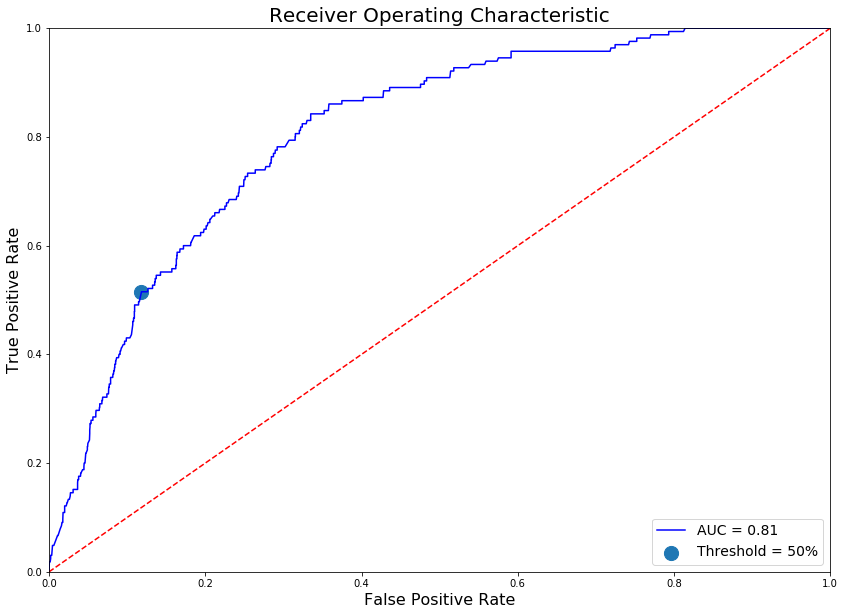

In [126]:
fpr, tpr, threshold = roc_curve(y_test, probas)
roc_auc = auc(fpr, tpr)

fix, ax = plt.subplots(figsize=(14,10))

plt.title('Receiver Operating Characteristic', fontsize=20)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.scatter(fpr[150], tpr[150], s=200, label='Threshold = 50%')
plt.legend(loc = 'lower right', fontsize=14)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=16)
plt.show()

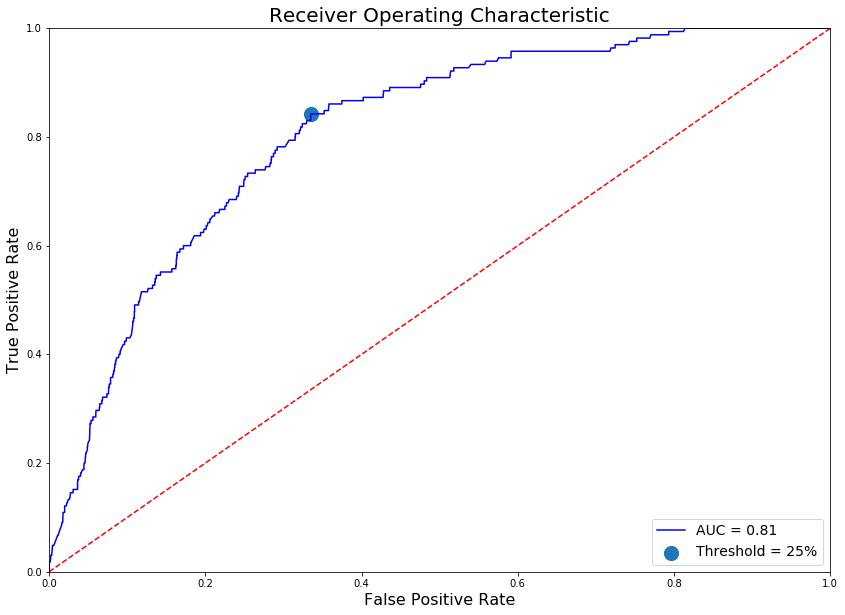

In [127]:
fpr, tpr, threshold = roc_curve(y_test, probas)
roc_auc = auc(fpr, tpr)

fix, ax = plt.subplots(figsize=(14,10))

plt.title('Receiver Operating Characteristic', fontsize=20)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.scatter(fpr[350], tpr[350], s=200, label='Threshold = 25%')
plt.legend(loc = 'lower right', fontsize=14)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=16)
plt.show()

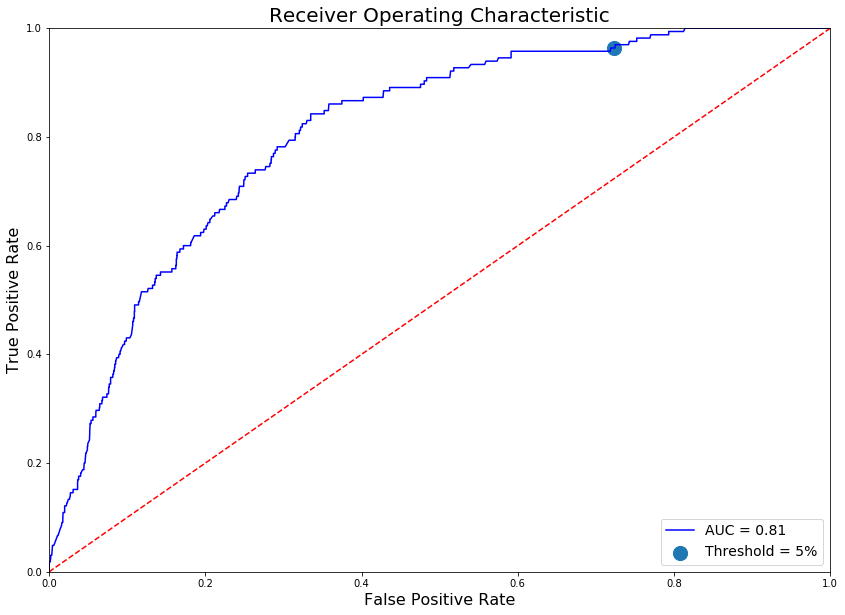

In [150]:
fpr, tpr, threshold = roc_curve(y_test, probas)
roc_auc = auc(fpr, tpr)

fix, ax = plt.subplots(figsize=(14,10))

plt.title('Receiver Operating Characteristic', fontsize=20)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.scatter(fpr[655], tpr[655], s=200, label='Threshold = 5%')
plt.legend(loc = 'lower right', fontsize=14)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=16)
plt.show()

In [125]:
threshold[350]

0.25003712822469315

In [149]:
threshold[655]

0.0502421412539015

## Kaggle Submission

In [267]:
Xs_holdout = ss.transform(X_holdout)

In [268]:
proba_pairs = rt_rand.predict_proba(Xs_holdout)
probas = [item[1] for item in proba_pairs]

In [361]:
submission = pd.DataFrame(probas)

In [271]:
submission.index += 1

In [363]:
# Manually entire 'Id', 'WnvPresent'
submission.to_csv('./kaggle_submission_1.csv')

In [299]:
Xs_holdout = ss.transform(X_holdout)
proba_pairs = rt_rand.predict_proba(Xs_holdout)
probas = [item[1] for item in proba_pairs]
submission = pd.DataFrame(probas)
submission.index += 1
submission.to_csv('./kaggle_submission_2.csv')

## Balance Classes by: Changing Threshold

In [152]:
def threshold_predict(probas, threshold):
    return probas[:,1] > threshold

In [158]:
probas = rt_rand.predict_proba(Xs_test)

new_preds = threshold_predict(probas, 0.05)

In [159]:
# Way too many false positives!

print(classification_report(y_test, new_preds))
pd.DataFrame(confusion_matrix(y_test, new_preds), columns=['Pred -', 'Pred +'], index=['Act -', 'Act +'])

             precision    recall  f1-score   support

          0       0.99      0.28      0.43      2959
          1       0.07      0.96      0.13       165

avg / total       0.94      0.31      0.42      3124



,Pred -,Pred +
Act -,817,2142
Act +,6,159


# -------------------THE GRAVEYARD OF FAILED IDEAS -----------------------------

## Balance Classes by: Oversampling (ros)

In [121]:
ros = RandomOverSampler(random_state=42)
X_over, y_over = ros.fit_sample(X, y)

In [122]:
print(X.shape)
print(y.shape)

(10413, 293)
(10413,)


In [123]:
print(X_over.shape)
print(y_over.shape)

(19724, 293)
(19724,)


In [124]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.3)

In [125]:
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [126]:
rf = RandomForestClassifier()
rf.fit(Xs_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [127]:
y_preds = rf.predict(X)
print(classification_report(y, y_preds))
pd.DataFrame(confusion_matrix(y, y_preds), columns=['Pred -', 'Pred +'], index=['Act -', 'Act +'])

             precision    recall  f1-score   support

          0       0.95      1.00      0.97      9862
          1       0.00      0.00      0.00       551

avg / total       0.90      0.95      0.92     10413



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Pred -,Pred +
Act -,9862,0
Act +,551,0


---

# Getting some Water Information (This takes too long too)

In [29]:
water = pd.read_csv('./Water_Locations.csv')

In [30]:
# Convert a polygon made of many lat/longs to one average lat/long point

def shape_to_point(shape_string):
    coord_list = shape_string.split(' ')[3:-1]
    lats = coord_list[1::2]
    longs = coord_list[0::2]
    
    clean_lat = []
    clean_long = []
    
    for i in range(len(lats)):
        clean_lat.append( float(lats[i].strip('(').strip(',').strip(')')) )
        clean_long.append( float(longs[i].strip('(').strip(',').strip(')')) )
        
    return(np.mean(clean_lat), np.mean(clean_long))

In [31]:
# Apply function to each body of water

latitudes = []
longitudes = []

for i in range(len(water)):
    latitudes.append(shape_to_point(water['the_geom'][i])[0])
    longitudes.append(shape_to_point(water['the_geom'][i])[1])
    
water['lat'] = latitudes
water['long'] = longitudes

In [36]:
# For each observation in Training Set, find the distance to closest body of water


min_dist = []

for i in range(len(X_train)):
    distances = []
    for j in range(len(water)):
        distances.append( vincenty((X_train['Latitude'][i], X_train['Longitude'][i]), (water['lat'][j], water['long'][j])).miles )
    if i % 100 == 0:
        print(i, 'rows parsed')
    min_dist.append(min(distances))

0 rows parsed
100 rows parsed
200 rows parsed
300 rows parsed
400 rows parsed
500 rows parsed
600 rows parsed
700 rows parsed
800 rows parsed
900 rows parsed
1000 rows parsed
1100 rows parsed
1200 rows parsed
1300 rows parsed
1400 rows parsed
1500 rows parsed
1600 rows parsed
1700 rows parsed
1800 rows parsed
1900 rows parsed
2000 rows parsed
2100 rows parsed
2200 rows parsed
2300 rows parsed
2400 rows parsed
2500 rows parsed
2600 rows parsed
2700 rows parsed
2800 rows parsed
2900 rows parsed
3000 rows parsed
3100 rows parsed
3200 rows parsed
3300 rows parsed
3400 rows parsed
3500 rows parsed
3600 rows parsed
3700 rows parsed
3800 rows parsed
3900 rows parsed
4000 rows parsed
4100 rows parsed
4200 rows parsed
4300 rows parsed
4400 rows parsed
4500 rows parsed
4600 rows parsed
4700 rows parsed
4800 rows parsed
4900 rows parsed
5000 rows parsed
5100 rows parsed
5200 rows parsed
5300 rows parsed
5400 rows parsed
5500 rows parsed
5600 rows parsed
5700 rows parsed
5800 rows parsed
5900 rows

In [37]:
# Generate Features
X_train['min_dist_water_miles'] = min_dist
X_train['min_dist_water_feet'] = [i*5280 for i in X_train['min_dist_water_miles'] ]

In [38]:
# For each observation in Testing Set, find the distance to closest body of water

min_dist = []

for i in range(len(X_test)):
    distances = []
    for j in range(len(water)):
        distances.append( vincenty((X_test['Latitude'][i], X_test['Longitude'][i]), (water['lat'][j], water['long'][j])).miles )
    if i % 100 == 0:
        print(i, 'rows parsed')
    min_dist.append(min(distances))

0 rows parsed
100 rows parsed
200 rows parsed
300 rows parsed
400 rows parsed
500 rows parsed
600 rows parsed
700 rows parsed
800 rows parsed
900 rows parsed
1000 rows parsed
1100 rows parsed
1200 rows parsed
1300 rows parsed
1400 rows parsed
1500 rows parsed
1600 rows parsed
1700 rows parsed
1800 rows parsed
1900 rows parsed
2000 rows parsed
2100 rows parsed
2200 rows parsed
2300 rows parsed
2400 rows parsed
2500 rows parsed
2600 rows parsed
2700 rows parsed
2800 rows parsed
2900 rows parsed
3000 rows parsed
3100 rows parsed
3200 rows parsed
3300 rows parsed
3400 rows parsed
3500 rows parsed
3600 rows parsed
3700 rows parsed
3800 rows parsed
3900 rows parsed
4000 rows parsed
4100 rows parsed
4200 rows parsed
4300 rows parsed
4400 rows parsed
4500 rows parsed
4600 rows parsed
4700 rows parsed
4800 rows parsed
4900 rows parsed
5000 rows parsed
5100 rows parsed
5200 rows parsed
5300 rows parsed
5400 rows parsed
5500 rows parsed
5600 rows parsed
5700 rows parsed
5800 rows parsed
5900 rows

46200 rows parsed
46300 rows parsed
46400 rows parsed
46500 rows parsed
46600 rows parsed
46700 rows parsed
46800 rows parsed
46900 rows parsed
47000 rows parsed
47100 rows parsed
47200 rows parsed
47300 rows parsed
47400 rows parsed
47500 rows parsed
47600 rows parsed
47700 rows parsed
47800 rows parsed
47900 rows parsed
48000 rows parsed
48100 rows parsed
48200 rows parsed
48300 rows parsed
48400 rows parsed
48500 rows parsed
48600 rows parsed
48700 rows parsed
48800 rows parsed
48900 rows parsed
49000 rows parsed
49100 rows parsed
49200 rows parsed
49300 rows parsed
49400 rows parsed
49500 rows parsed
49600 rows parsed
49700 rows parsed
49800 rows parsed
49900 rows parsed
50000 rows parsed
50100 rows parsed
50200 rows parsed
50300 rows parsed
50400 rows parsed
50500 rows parsed
50600 rows parsed
50700 rows parsed
50800 rows parsed
50900 rows parsed
51000 rows parsed
51100 rows parsed
51200 rows parsed
51300 rows parsed
51400 rows parsed
51500 rows parsed
51600 rows parsed
51700 rows

KeyboardInterrupt: 

In [ ]:
# Generate Features
X_test['min_dist_water_miles'] = min_dist
X_test['min_dist_water_feet'] = [i*5280 for i in X_test['min_dist_water_miles'] ]

---
# Getting some Park Information (This Section on Hold, takes a lot of time)

In [21]:
parks = pd.read_csv('./Park_Locations.csv')

In [22]:
park_feats = ['PARK NUMBER', 'PARK NAME', 'STREET ADDRESS', 'ZIP', 'ACRES', 'WARD', 'PARK CLASS', 'LABEL', 'LOCATION']

In [23]:
parks = parks[park_feats]

In [24]:
parks.head()

,PARK NUMBER,PARK NAME,STREET ADDRESS,ZIP,ACRES,WARD,PARK CLASS,LABEL,LOCATION
0,288,GOLDEN GATE,500 E 130TH ST,60627.0,5.20,9,COMMUNITY PARK,Golden Gate,500 E 130TH ST\n60627\n
1,548,MAJOR TAYLOR BIKE TRAIL,NaN,NaN,31.24,0,COMMUNITY PARK,Major Taylor Bike Trail,NaN
2,255,CARVER (GEORGE WASHINGTON),939 E 132ND ST,60627.0,19.42,9,REGIONAL PARK,Carver,939 E 132ND ST\n60627\n
3,127,RUTHERFORD SAYRE,6871 W BELDEN AVE,60635.0,12.33,36,COMMUNITY PARK,Rutherford Sayre,6871 W BELDEN AVE\n60635\n
4,1256,HOWARD (URE) BEACH,1300 W HOWARD ST,60626.0,0.89,49,NEIGHBORHOOD PARK,Howard Beach,"1300 W HOWARD ST\n60626\n(42.01933233897205, -..."


In [25]:
geolocator = Nominatim()
location = geolocator.geocode("500 E 130TH ST CHICAGO")
print((location.latitude, location.longitude))

(41.6590468805167, -87.6093631364668)


In [90]:
lats = []
longs = []
geolocator = Nominatim()

for i in range(len(parks)):
    loc = geolocator.geocode(parks['STREET ADDRESS'][i])
    try:
        lats.append(loc.latitude)
    except:
        lats.append(np.nan)
    try:
        longs.append(loc.longitude)
    except:
        longs.append(np.nan)
        
    time.sleep(5)

GeocoderTimedOut: Service timed out